# GSoC 2023 ML4SCI QML-HEP Tasks

Marçal Comajoan Cara

## Task VI: Quantum Representation Learning

### Task statement

In this task you should implement a simple representation learning scheme based on a contrastive loss:
- Load the MNIST dataset.
- Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations.
- Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
- Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.

---

### Introduction

For this task, I will create a quantum siamese convolutional neural network with a contrastive loss function to classify the MNIST digits dataset. Siamese networks are a type of neural network architecture that utilizes shared weights between two sibling networks, with each generating embedding vectors for their corresponding inputs. This approach is particularly effective in representation learning, as it enables the model to learn meaningful and discriminative feature representations of the data.

In the context of supervised similarity learning, Siamese networks are trained to optimize the contrast between embedding vectors of different classes, while minimizing the distance between vectors of similar classes. This results in an embedding space that accurately reflects the class segmentation of the training inputs, ultimately enhancing the model's ability to identify and classify new instances. 

To show more clearly the architecture and see how it compares to a classical network of the same characteristics, I will also create first a classical siamese convolutional neural network.

I will use the PyTorch deep learning library [1] and PennyLane [2] for defining the quantum circuits. PennyLane is a good choice as it provides many gates and integrates seamlessly with PyTorch.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import torch
import pennylane as qml
import pennylane.numpy as np
from torchvision import datasets, transforms
import torch.nn as nn

datasets_dir = os.path.expanduser("~/datasets")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### MNIST dataset preparation for training with contrastive loss

First, we have to create a dataset to train the siamese neural network. In a siamese neural network, instead of providing single examples corresponding to different single labels (e.g., an image of a one, with a label 1; an image of a seven, with a label 7; etc.) we have to provide two images as input and the label indicates if they are from the same class or not. For example, if we provide two images of a seven, the label will be 1, whereas if we provide an image of a one and an image of a seven the label will be 0.

To do this, we load the original MNIST dataset from `torchvision` and create a new "contrastive dataset". We do this by generating a negative example (0) when the index of the example is even, and a positive one (1) when it is odd. To generate the examples, two random images are selected, ensuring that they are correspondingly negative or positive.

In [2]:
class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, *mnist_args, **mnist_kwargs):
        super(ContrastiveDataset, self).__init__()
        
        self.dataset = datasets.MNIST(*mnist_args, **mnist_kwargs)
        
        targets = np.array(self.dataset.targets.clone())
        
        self.grouped_examples = {}
        for i in range(10):
            self.grouped_examples[i] = np.where((targets == i))[0]
            
    def __len__(self):
        return self.dataset.data.shape[0]
    
    def __getitem__(self, index):
        # Pick some random class for the first image
        selected_class = random.randint(0, 9)

        # Pick a random index for the first image in the grouped indices based of the label of the class
        random_index_1 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        
        # Pick the index to get the first image
        index_1 = self.grouped_examples[selected_class][random_index_1]

        # Set the first image
        image_1 = self.dataset[index_1][0].clone().float()#.unsqueeze(0)

        # Same class
        if index % 2 == 0:
            # Pick a random index for the second image
            random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
            
            # Ensure that the index of the second image is not the same as the first image
            while random_index_2 == random_index_1:
                random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
            
            # Pick the index to get the second image
            index_2 = self.grouped_examples[selected_class][random_index_2]

            # Get the second image
            image_2 = self.dataset[index_2][0].clone().float()#.unsqueeze(0)

            # Set the label for this example to be positive (1)
            target = torch.tensor(1, dtype=torch.float)
        
        # Different class
        else:
            # Pick a random class
            other_selected_class = random.randint(0, 9)

            # Ensure that the class of the second image is not the same as the first image
            while other_selected_class == selected_class:
                other_selected_class = random.randint(0, 9)

            
            # Pick a random index for the second image in the grouped indices based of the label of the class
            random_index_2 = random.randint(0, self.grouped_examples[other_selected_class].shape[0]-1)

            # Pick the index to get the second image
            index_2 = self.grouped_examples[other_selected_class][random_index_2]

            # Get the second image
            image_2 = self.dataset[index_2][0].clone().float()#.unsqueeze(0)

            # Set the label for this example to be negative (0)
            target = torch.tensor(0, dtype=torch.float)

        return image_1, image_2, target

The original MNIST images are $28\times 28$. We reduce them to $16\times 16$ so that we do not need to create a very large quantum circuit. With a $16\times 16$ image we have 256 pixels, therefore with an amplitude embedding we will need $\log_2 256 = 8$ qubits to encode the image into the quantum circuit. Note that I find that with smaller image sizes many images are difficult to classify correctly even for me, as the quality is reduced too much.

In [3]:
transform = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_set = ContrastiveDataset(root=datasets_dir, train=True, download=True, transform=transform)
test_set = ContrastiveDataset(root=datasets_dir, train=False, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64)

Just to show how the dataset looks, let us see a positive example and a negative example. 

In [4]:
images1, images2, targets = next(iter(train_dataloader))

Here we can see a positive example:

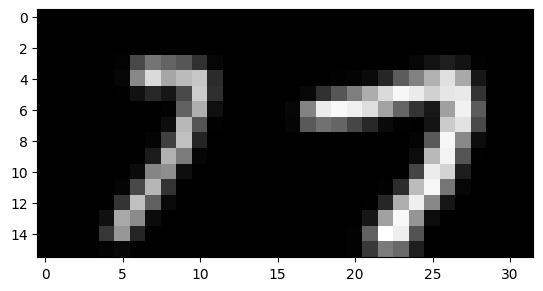

In [5]:
same_class_index = np.where(targets == 1)[0][0]
plt.imshow(torch.cat((images1[same_class_index], images2[same_class_index]), -1).squeeze(), cmap='gray');

The network should be trained to reduce their dissimilarity and predict 1.

And here is a negative example:

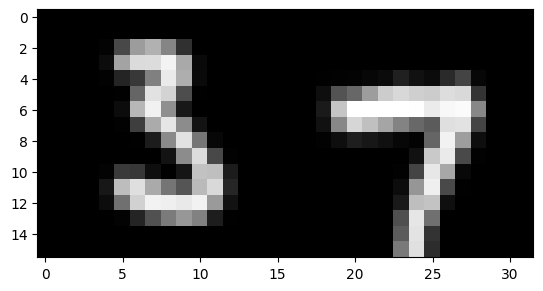

In [6]:
different_class_index = np.where(targets == 0)[0][0]
plt.imshow(torch.cat((images1[different_class_index], images2[different_class_index]), -1).squeeze(), cmap='gray');

Here, the network should be trained to increase their dissimilarity and predict 0.

### Classical Siamese Neural Network

Now, let us define the classical siamese neural network [3], which will help to see more clearly the architecture defined in the quantum siamese neural network that follows later.

I tried to create a simple siamese convolutional neural network with few parameters, to make it comparable to its quantum counterpart. It starts with a batch normalization layer, followed by two Convolution + ReLU + Max Pooling blocks. The first convolution has 1 input channel, since the input images are in grayscale, and 4 output channels, with a $5x5$ kernel. The second convolution has 4 input channels and 16 output channels, and a $5\times 5$ kernel too. Both max pooling layers have $2\times 2$ kernels. After this, a linear layer is applied with ten neurons. Each of the two received images are processed by this CNN part. Then, the Euclidean distance between the two resulting 10-elements embeddings is computed, and it is passed through a neuron with sigmoid activation to get the class probability (recall that the classes here are binary). The model returns both the class probability and the distance, which acts as a dissimilarity or fidelity measure.

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 4, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
            
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(16, 10),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.conv(x)
        output = self.flatten(output)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        dist = torch.nn.functional.pairwise_distance(output1, output2, keepdim=True)
        return self.fc2(dist).squeeze(), dist.squeeze()


To train the siamese neural network, we use the contrastive loss [4], which we define next:

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, m=1):
        super(ContrastiveLoss, self).__init__()
        self.m = m
        
    def forward(self, y_true, y_pred):
        square_pred = torch.pow(y_pred, 2)
        margin_square = torch.pow(torch.clamp(self.m - y_pred, 0), 2)
        loss = torch.mean((1 - y_true)*square_pred + y_true*margin_square)
        return loss

Finally, let us train the model. We will train it for 10 epochs using the Adam optimizer with the default hyperparameters.

In [9]:
def train(model, device, train_dataloader, optimizer):
    correct = 0
    model.train()
    criterion = ContrastiveLoss()
    for images1, images2, y_true in train_dataloader:
        images1, images2, y_true = images1.to(device), images2.to(device), y_true.to(device)
        optimizer.zero_grad()
        y_pred, dist = model(images1, images2)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        correct += ((y_pred > 0.5) == y_true).sum().item()
    return correct / len(train_dataloader.dataset)
    
def test(model, device, test_dataloader):
    correct = 0
    model.eval()
    with torch.no_grad():
        for images1, images2, y_true in test_dataloader:
            images1, images2, y_true = images1.to(device), images2.to(device), y_true.to(device)
            y_pred, dist = model(images1, images2)
            correct += ((y_pred > 0.5) == y_true).sum().item()
    return correct / len(test_dataloader.dataset)

model = SiameseNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    print(f"Epoch {epoch}")
    print(f' TRAINING\tAccuracy: {train(model, device, train_dataloader, optimizer):.6f}')
    print(f" TESTING \tAccuracy: {test(model, device, test_dataloader):.6f}")

Epoch 0
 TRAINING	Accuracy: 0.514167
 TESTING 	Accuracy: 0.625200
Epoch 1
 TRAINING	Accuracy: 0.766700
 TESTING 	Accuracy: 0.862000
Epoch 2
 TRAINING	Accuracy: 0.877983
 TESTING 	Accuracy: 0.894100
Epoch 3
 TRAINING	Accuracy: 0.902100
 TESTING 	Accuracy: 0.914200
Epoch 4
 TRAINING	Accuracy: 0.917083
 TESTING 	Accuracy: 0.918300
Epoch 5
 TRAINING	Accuracy: 0.920767
 TESTING 	Accuracy: 0.925000
Epoch 6
 TRAINING	Accuracy: 0.927600
 TESTING 	Accuracy: 0.933300
Epoch 7
 TRAINING	Accuracy: 0.929050
 TESTING 	Accuracy: 0.936400
Epoch 8
 TRAINING	Accuracy: 0.933467
 TESTING 	Accuracy: 0.937900
Epoch 9
 TRAINING	Accuracy: 0.936100
 TESTING 	Accuracy: 0.939200


We obtain an accuracy of 93.92% on the test set, which is pretty good.

Finally, let us visualize some predictions to see how the model really works. The color indicates the true class (green for same class, red for different class)

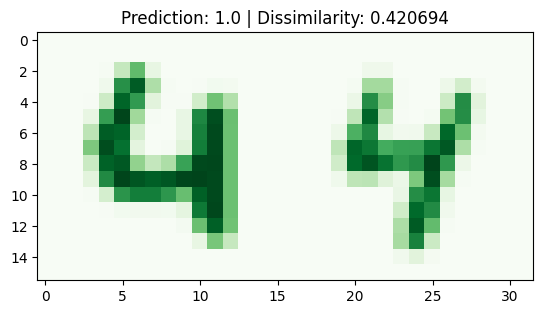

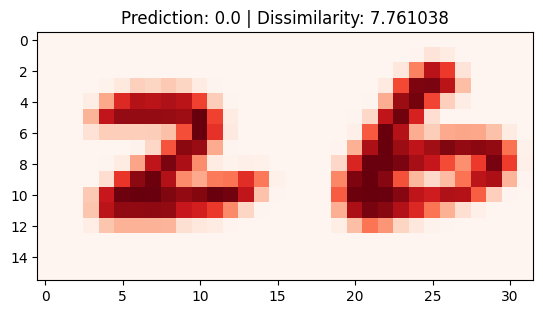

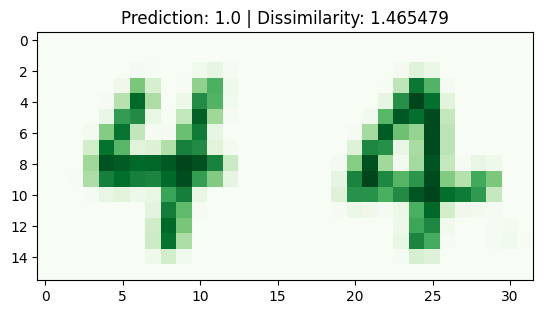

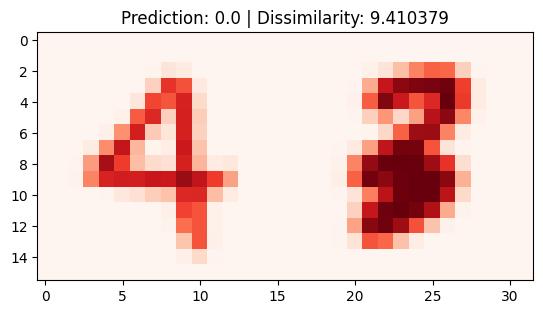

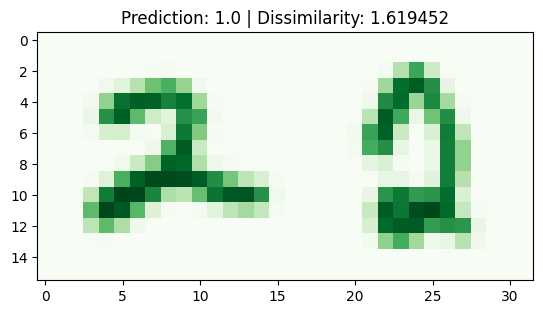

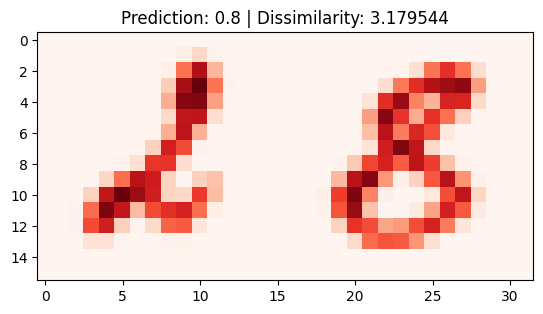

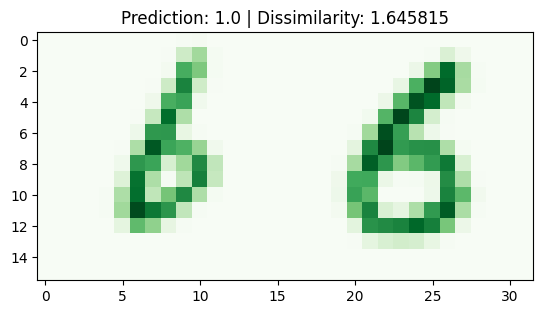

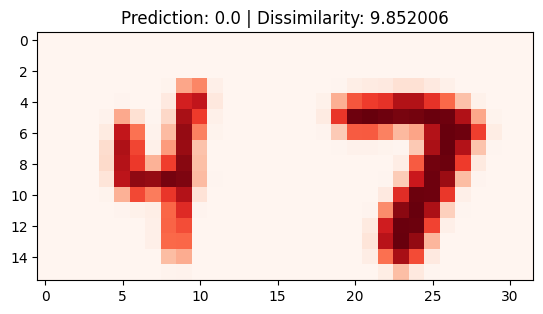

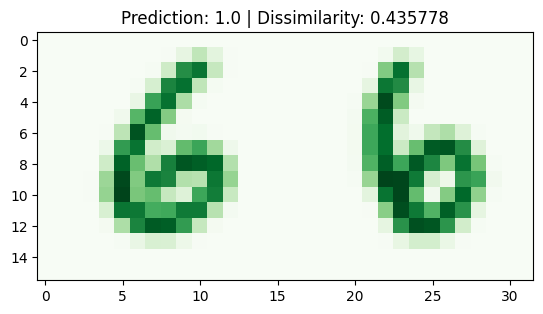

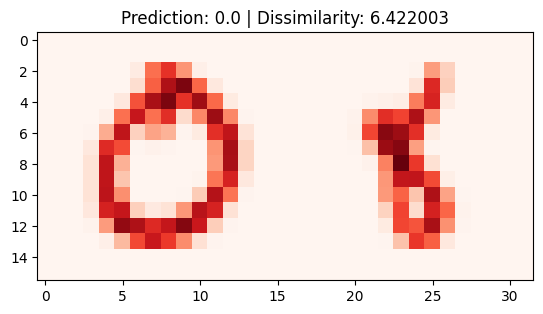

In [10]:
model.eval()
with torch.no_grad():
    images1, images2, targets = next(iter(test_dataloader))
    for i in range(10):
        plt.figure()
        input1, input2 = images1[i].to(device), images2[i].to(device)
        pred, dist = model(input1.unsqueeze(0), input2.unsqueeze(0))
        plt.title(f"Prediction: {pred:.1f} | Dissimilarity: {dist:.6f}")
        plt.imshow(torch.cat((images1[i], images2[i]), -1).squeeze(), cmap='Greens' if targets[i] else 'Reds')

We can see that most of the predictions are correct and that the dissimilarity measure works quite good too.

### Quantum Siamese Neural Network (QSNN)

Next, we will define a similar architecture within the quantum domain. For the quantum convolutional neural network component, we will utilize the types of quantum circuits suggested in [5]. The implementation is based on the PennyLane documentation example provided in [6].

In this architecture, we employ a siamese quantum circuit, which consists of two separate 8-qubit circuits with identical gate structures and shared parameters. Each circuit contains two Convolution + Pooling layers, followed by a densely-connected linear layer. At the end of these circuits, the SWAP test is performed between the final states of both circuits, and the fidelity between both is measured on the ancilla qubit of the SWAP test. In total, the circuit requires $8+8+1=17$ qubits

Within these quantum circuits, the convolutional layer is represented by a two-qubit unitary operation that establishes correlations between adjacent qubits as the kernel traverses the entire input. This arbitrary two-qubit unitary is implemented using two single-qubit U3 gates (parametrized by three parameters, each), three Ising interactions between both qubits (each interaction is parametrized by one parameter), and two additional U3 gates on each of the two qubits. For the pooling layer, we implement a conditioned single-qubit unitary operation, which relies on the measurement of a neighboring qubit, reducing our system size by a factor of 2. Finally, the dense layer incorporates an all-to-all unitary gate to entangle all the qubits in the final state.

To encode the classical data into the quantum circuit, an amplitude embedding is used. Using PennyLane's [`AmplitudeEmbedding`](https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html) directly gives an error, since multiple state preparations are not supported. However, we can circumvent this problem by using the [`MottonenStatePreparation`](https://docs.pennylane.ai/en/stable/code/api/pennylane.MottonenStatePreparation.html) [7], which in fact is the method used by `AmplitudeEmbedding` when the 
operation is not supported natively on the target device.

A full plot of the circuit is displayed at the end of the following cell, which defines the whole quantum architecture: 

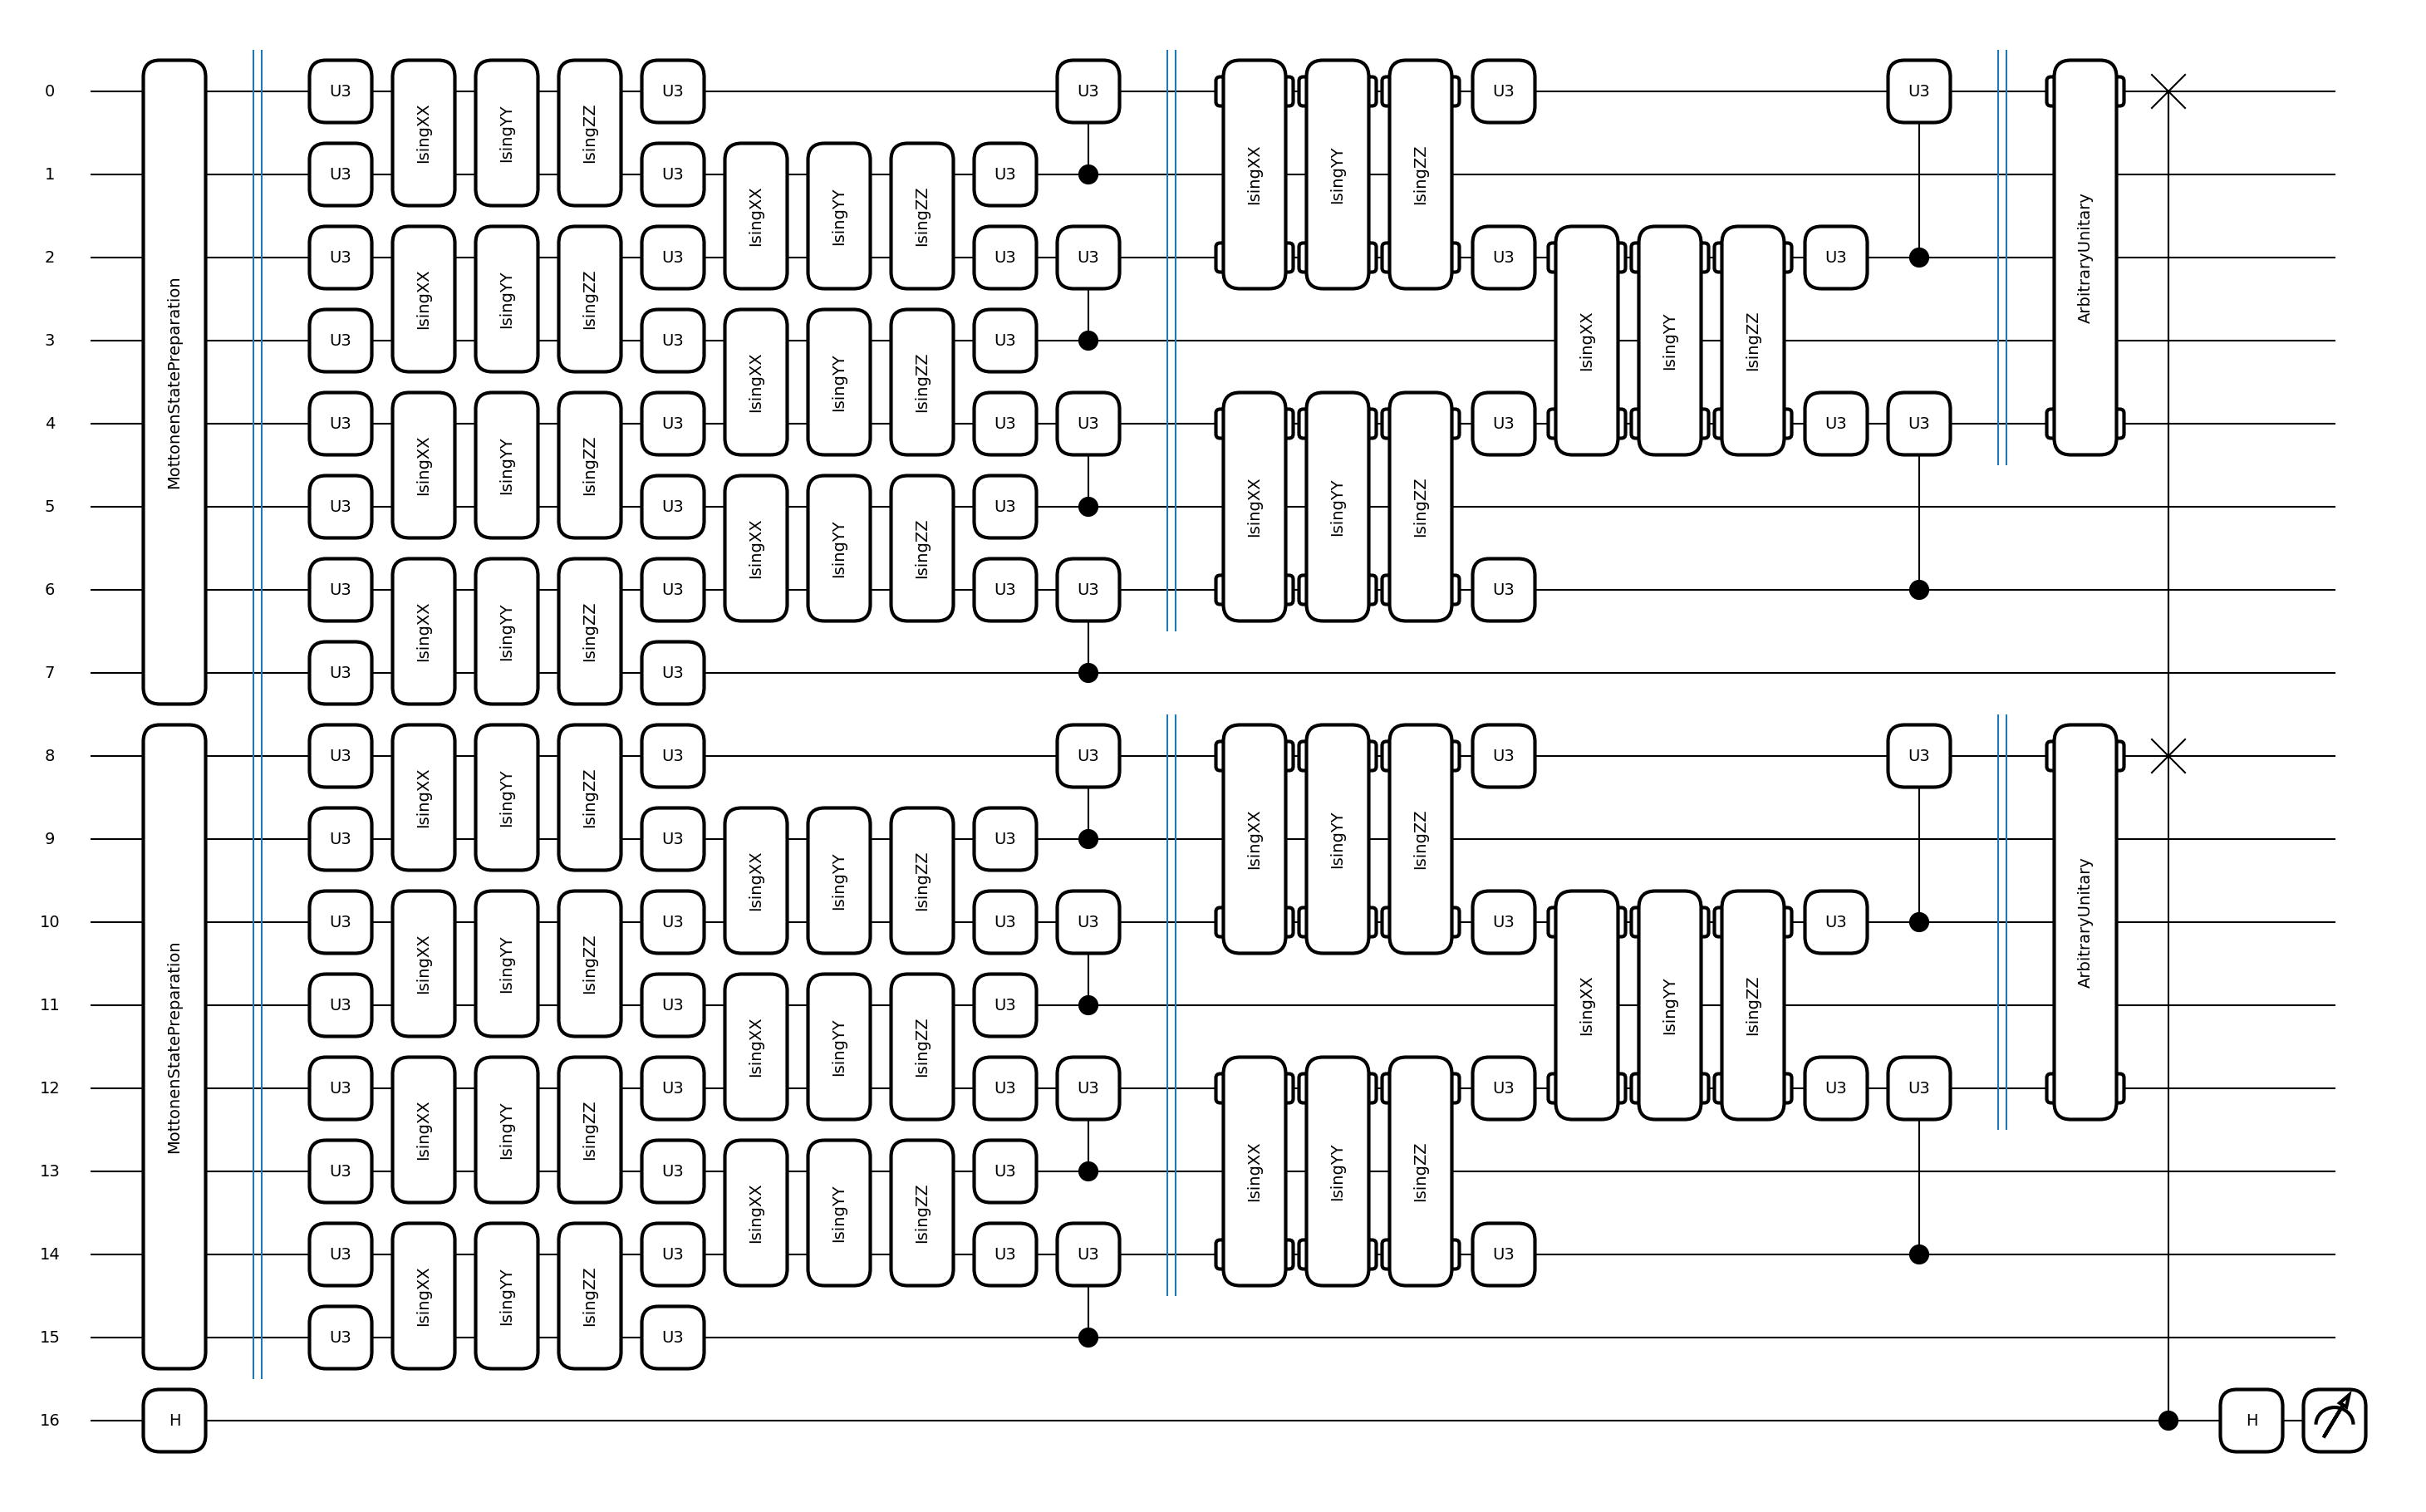

In [11]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """
    Adds a convolutional layer to a circuit.
    Args:
        weights: 1D array with 15 weights of the parametrized gates.
        wires: Wires where the convolutional layer acts on.
        skip_first_layer: Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])
                
def pooling_layer(weights, wires):
    """
    Adds a pooling layer to a circuit.
    Args:
        weights: Array with the weights of the conditional U3 gate.
        wires: List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])
            
def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""
    convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pooling_layer(kernel_weights[15:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    qml.ArbitraryUnitary(weights, wires)
    

def qcnn(weights, last_layer_weights, features, wires):
    """
    Define the QCNN circuit
    Args:
        weights: Parameters of the convolution and pool layers.
        last_layer_weights: Parameters of the last dense layer.
        features: Input data to be embedded using AmplitudEmbedding.
    """

    layers = weights.shape[1]

    # inputs the state input_state
    # qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.MottonenStatePreparation(state_vector=features, wires=wires)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    last_layer_weights_size = np.prod(last_layer_weights.shape)
    assert last_layer_weights_size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!\n"
        f"Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights_size}"
    )
    dense_layer(last_layer_weights, wires)


device = qml.device("default.qubit.torch", wires=17)

@qml.qnode(device, interface="torch")
def qsnn(weights, last_layer_weights, input1, input2):
    qcnn(weights, last_layer_weights, input1, list(range(0, 8)))
    qcnn(weights, last_layer_weights, input2, list(range(8, 16)))
    
    # SWAP test
    qml.Hadamard(wires=[16])
    qml.CSWAP(wires=[16, 0, 8])
    qml.Hadamard(wires=[16])
    return qml.probs(wires=[16])


in1 = torch.rand(16*16)
in2 = torch.rand(16*16)
in1 /= torch.norm(in1)
in2 /= torch.norm(in2)
fig, ax = qml.draw_mpl(qsnn)(
    torch.rand(18, 2), torch.rand(4 ** 2 - 1), in1, in2
)

The `MottonenStatePreparation` seems to have problems with batched input, so we use a batch size of 1.

In [12]:
# train_set = torch.utils.data.Subset(train_set, torch.arange(100))
# test_set = torch.utils.data.Subset(test_set, torch.arange(100))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1)

Finally, let us train the quantum circuits!

As the QSNN output is the result of the SWAP test, it ranges from 0.5 to 1, but we want a value ranging from 0 to 1, so we subtract 0.5 and multiply it by two before applying the contrastive loss. Recall that the result of the SWAP test is 0.5 if the states are orthogonal, and 1 if the states are equal.

In [13]:
def train(weights, last_layer_weights, train_dataloader, optimizer):
    correct = 0
    criterion = ContrastiveLoss()
    for images1, images2, y_true in train_dataloader:
        images1 = torch.flatten(images1, start_dim=1)
        images2 = torch.flatten(images2, start_dim=1)
        images1 /= torch.linalg.vector_norm(images1, dim=1, keepdim=True)
        images2 /= torch.linalg.vector_norm(images2, dim=1, keepdim=True)
        optimizer.zero_grad()
        p = qsnn(weights, last_layer_weights, images1.squeeze(), images2.squeeze())[0]  # probability that 0 is measured, between 0.5 and 1
        y_pred = (p - 0.5) * 2  # convert to probability between 0 and 1, to represent probability of being of the same class
        loss = criterion(y_pred, y_true.squeeze().double())
        loss.backward()
        optimizer.step()
        correct += ((y_pred > 0.5) == y_true).sum().item()
    return correct / len(train_dataloader.dataset)
    
def test(weights, last_layer_weights, test_dataloader):
    correct = 0
    with torch.no_grad():
        for images1, images2, y_true in test_dataloader:
            images1 = torch.flatten(images1, start_dim=1)
            images2 = torch.flatten(images2, start_dim=1)
            images1 /= torch.linalg.vector_norm(images1, dim=1, keepdim=True)
            images2 /= torch.linalg.vector_norm(images2, dim=1, keepdim=True)
            p = qsnn(weights, last_layer_weights, images1.squeeze(), images2.squeeze())[0]
            y_pred = (p - 0.5) * 2
            correct += ((y_pred > 0.5) == y_true).sum().item()
    return correct / len(test_dataloader.dataset)

weights = torch.randn(18, 2, requires_grad=True)
last_layer_weights = torch.randn(4**2 - 1, requires_grad=True)
optimizer = torch.optim.Adam([weights, last_layer_weights])

for epoch in range(10):
    print(f"Epoch {epoch}")
    print(f' TRAINING\tAccuracy: {train(weights, last_layer_weights, train_dataloader, optimizer):.6f}')
    print(f" TESTING \tAccuracy: {test(weights, last_layer_weights, test_dataloader):.6f}")

Epoch 0


KeyboardInterrupt: 

Unfortunately, the quantum circuits defined seems to take a really long time to train. I have waited for more than a day, and the training process has yet to complete its first epoch on my computer. One of the causes for this is that the whole circuit has many qubits, so it takes longer to simulate and train. The number of parameters also is not very low ($(18\cdot2)+(4^2-1)=36+15=51$). Moreover, using a batch size of 1 further prolongs the training process. Lastly, another contributing factor to this is that the training set is quite big too, as it contains 60,000 examples. I tried reducing its size, but it still took a lot, and with extremely low values the circuit did not learn much as it did not have enough samples.

### References

1. [PyTorch](https://pytorch.org/)
2. [PennyLane](https://pennylane.ai/)
3. [Image similarity estimation using a Siamese Network with a contrastive loss (Keras)](https://keras.io/examples/vision/siamese_contrastive)
4. [Raúl Gomez. Understanding Ranking Loss, Contrastive Loss, Margin Loss, Triplet Loss, Hinge Loss and all those confusing names (2019)](https://gombru.github.io/2019/04/03/ranking_loss/)
5. [Iris Cong et al. Quantum Convolutional Neural Networks (2018)](https://arxiv.org/abs/1810.03787)
6. [Generalization in QML from few training data (PennyLane)](https://pennylane.ai/qml/demos/tutorial_learning_few_data.html)